In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.sgdr import *
from fastai.imports import *
from fastai.dataset import *
from fastai.model import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.plots import *


In [3]:
PATH = '../data/PlantSeedlings/'
os.listdir(PATH)

['train.zip', 'test', 'label.csv', 'models', 'train', 'tmp', 'test.zip']

In [1]:
#species = os.listdir(f'{PATH}train')

In [12]:
def create_label_csv(path):
    label_csv = pd.DataFrame(columns=['file','species'])
    for spe in species:
        for file in os.listdir(path+'train/'+spe+'/'):
            label_csv = label_csv.append({'file':file,
                              'species':spe.replace(' ','_')}
                             ,ignore_index = True)
    return label_csv
label_csv = create_label_csv(PATH)
label_csv.to_csv(f'{PATH}label.csv',index=False)

In [7]:
def movefiles():
    dst = f'{PATH}/train/'
    srcs = [f'{PATH}train/{spe}' for spe in species]
    for src in srcs:
        for file in os.listdir(src):
            src_file = src+'/'+file
            dst_file = dst + '/'+file
            shutil.move(src_file,dst_file)
movefiles()

In [8]:
def removeEmptyDir():
    path = f'{PATH}/train/'
    for d in species:
        os.removedirs(path+d)
        
removeEmptyDir()

In [4]:
df = pd.read_csv(f'{PATH}label.csv')
df.pivot_table(index='species',aggfunc = len).sort_values('file',ascending=False)

,file
species,
Loose_Silky-bent,654
Common_Chickweed,611
Scentless_Mayweed,516
Small-flowered_Cranesbill,496
Fat_Hen,475
Charlock,390
Sugar_beet,385
Cleavers,287
Black-grass,263


In [17]:
df.shape
for i in range(df.shape[0]):
    df.species[i] = df.species[i].replace(' ','_')

In [18]:
df.pivot_table(index='species',aggfunc = len).sort_values('file',ascending=False)

,file
species,
Loose_Silky-bent,654
Common_Chickweed,611
Scentless_Mayweed,516
Small-flowered_Cranesbill,496
Fat_Hen,475
Charlock,390
Sugar_beet,385
Cleavers,287
Black-grass,263


In [6]:
df.to_csv(f'{PATH}label.csv',index=False)

In [5]:
val_idxs = get_cv_idxs(df.shape[0])
val_idxs[:3],len(val_idxs)

(array([3817, 1075,  296]), 950)

In [6]:
def f1(preds, targs):
    preds = np.argmax(preds, 1)
    return sklearn.metrics.f1_score(targs, preds, average='micro') 

In [7]:
arch = resnet50
sz = 400
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train',f'{PATH}label.csv',tfms=tfms,val_idxs= val_idxs,test_name = 'test')

In [8]:
learn = ConvLearner.pretrained(arch,data,precompute=True,metrics=[f1])

In [60]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▌| 57/60 [00:01<00:00, 48.78it/s, loss=10.8]


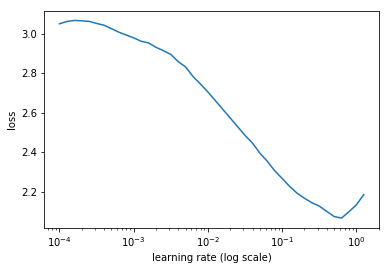

In [61]:
learn.sched.plot()

In [10]:
learn.fit(0.1,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   f1                       
    0      1.30846    0.585724   0.808681  
    1      0.902655   0.470817   0.839468                  



[0.47081745, 0.8394675925925926]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 51/60 [00:01<00:00, 49.30it/s, loss=1.06] 


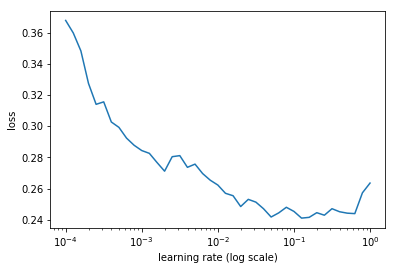

In [68]:
learn.lr_find()
learn.sched.plot()

In [14]:
precompute = False
learn.fit(1e-2,3, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f1                        
    0      0.488363   0.374928   0.882176  
    1      0.425664   0.421997   0.879051                  
    2      0.398793   0.37557    0.884452                  



[0.37557048, 0.8844521604938272]

In [15]:
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze()
learn.fit(lrs,3, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f1                        
    0      0.459468   0.304538   0.897801  
    1      0.446972   0.292676   0.90216                   
    2      0.415388   0.294271   0.901119                  
    3      0.416273   0.285949   0.897145                  
    4      0.3948     0.275549   0.909645                  
    5      0.3758     0.274121   0.905093                  
    6      0.375484   0.271417   0.90841                   



[0.27141675, 0.9084104938271605]

In [17]:
learn.freeze()
learn.fit(lr,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f1                        
    0      0.365617   0.27211    0.909259  
    1      0.364471   0.265937   0.905285                  
    2      0.350252   0.265096   0.90652                   



[0.2650955, 0.906520061728395]

In [12]:
learn.precompute = False
learn.load('400')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 56/60 [01:23<00:05,  1.50s/it, loss=1.16] 

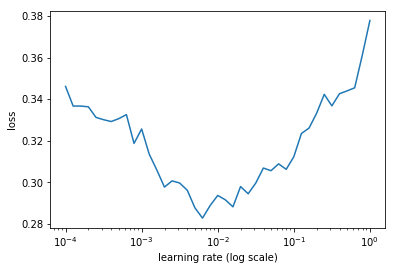

In [70]:
learn.lr_find()
learn.sched.plot()

In [71]:
learn.save('400')

In [72]:

learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/60 [00:00<?, ?it/s]                    


Exception in thread Thread-68:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.317429   0.22908    0.925656  
    1      0.330705   0.224264   0.924614                  
    2      0.331236   0.227205   0.928781                  
    3      0.316454   0.223874   0.927739                  
    4      0.316014   0.219602   0.928781                  
    5      0.296106   0.219322   0.929823                  
    6      0.277768   0.218473   0.930864                  



[0.21847278, 0.9308641990025838]

In [73]:
learn.save('400')

In [74]:
data.val_y

array([11, 11,  2,  3,  3, 10,  8,  7,  4,  9, 11, 10,  1,  7,  5,  8,  8,  1,  5,  3,  8,  9,  6,  2, 10,
        3,  3, 10,  8,  6,  2, 10, 11,  0,  0,  3,  9,  6,  6,  7,  5,  8,  3,  4,  3, 10,  1,  3,  8,  3,
        5,  1,  3,  9,  8,  1,  2,  6,  2,  3,  1, 10,  8,  6,  0,  5,  1,  8,  8,  8, 11, 11,  5,  3, 11,
        1,  6, 10,  3,  5, 11, 10,  6,  4,  8,  5,  4,  8, 11,  4, 10,  6,  9,  3,  3,  5,  9,  3,  5,  9,
        3,  0,  7,  6, 10,  1,  6,  6,  9,  6,  6,  8,  1,  7, 10,  9,  5,  6,  3,  5,  6,  4, 10,  4,  0,
        9,  1, 11,  3,  2,  5,  9, 11,  4,  1,  1,  3,  1,  3,  8,  1,  6,  6,  1,  1,  3, 11,  3,  3, 10,
        8,  6,  3,  6,  2,  5,  5,  6,  2, 10,  6,  5,  3,  2,  6,  5,  8,  8, 10, 10, 10, 11, 10, 11, 11,
        3, 11,  3, 11, 10,  5,  8,  7,  3,  7,  8, 10,  5,  8, 11,  5,  4,  3,  6,  3,  5, 10,  0,  3,  1,
       10, 11,  1,  8,  3,  6,  8,  1,  4,  2,  1,  1,  7,  6,  5,  1,  3,  2,  7,  2, 10,  8,  3,  5,  7,
        4, 10,  8,  3,  3,  3,  6,  8

In [75]:
val = learn.predict()

In [79]:
val.shape
a = np.argmax(val,1)

array([11, 11,  2,  3,  3, 10,  8,  7,  4,  8, 11, 10,  1,  7,  5,  8,  8,  1,  5,  3,  8,  9,  6,  2, 10,
        3,  3, 10,  8,  6,  2, 10, 11,  0,  0,  3,  9,  6,  6,  7,  4,  8,  3,  4,  3, 10,  1,  3,  8,  3,
        5,  1,  3,  9,  8,  1,  2,  6,  2,  3,  1, 10,  8,  6,  0,  5,  1,  8,  3,  8, 11, 11,  5,  3, 11,
        1,  6, 10,  3,  5, 11, 10,  6,  4,  8,  5,  4,  8, 11,  4, 10,  6,  9,  3,  3,  5,  9,  3,  5,  9,
        3,  0,  7,  6, 10,  1,  6,  0,  9,  6,  0,  8,  1,  7, 10,  9,  5,  6,  3,  5,  6,  4, 10, 11,  4,
        9,  1, 11,  3,  2,  5,  9, 11,  4,  1,  1,  3,  1,  3,  8,  1,  6,  6,  1,  1,  3, 11,  3,  3, 10,
        3,  6,  3,  0,  2,  5,  5,  6,  2, 10,  6,  5,  3,  2,  6,  5,  8,  8, 10, 10, 10, 11, 10, 11, 11,
        3, 11,  3, 11, 10,  5,  8,  7,  3,  7,  8, 10,  5,  8, 11,  5,  4,  3,  6,  3,  5, 10,  6,  3,  1,
       10, 11,  1,  8,  3,  6,  8,  1,  4,  2,  1,  1,  7,  6,  5,  1,  3,  2,  7,  2, 10,  8,  3,  5,  7,
        4, 10,  8,  3,  3,  3,  6,  8

In [81]:
def f1(preds, targs):
    preds = np.argmax(preds, 1)
    return sklearn.metrics.f1_score(targs, preds, average='micro') 

learn.metrics = [f1]
learn.fit(lr,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f1                        
    0      0.316553   0.218854   0.925463  



[0.21885352, 0.9254629629629629]

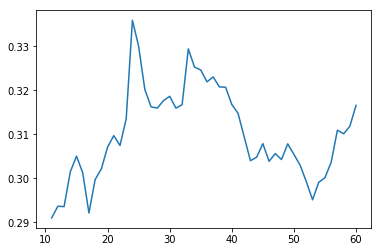

In [83]:
learn.sched.plot_loss()

In [84]:
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f1                        
    0      0.308158   0.223338   0.924807  
    1      0.304464   0.21991    0.930864                  
    2      0.277463   0.214537   0.930864                  
    3      0.284043   0.214311   0.924614                  
    4      0.272641   0.214652   0.932948                  
    5      0.287109   0.20986    0.93588                   
    6      0.281503   0.213958   0.929823                  



[0.21395761, 0.9298225308641975]

In [86]:
learn.save('400')

In [87]:
def get_data(sz):
    tfms = tfms_from_model(arch,sz=sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train',f'{PATH}label.csv',tfms=tfms,val_idxs= val_idxs,test_name = 'test')
    return data

learn.set_data(get_data(500))

In [88]:
learn.freeze()
learn.fit(lr,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   f1                        
    0      0.367512   0.234721   0.926698  
    1      0.342962   0.231551   0.925656                  
    2      0.329632   0.235474   0.922531                  



[0.23547392, 0.9225308641975309]

In [13]:
pred = learn.predict()

In [16]:
y_pred = np.argmax(pred,1)

In [20]:
y_pred.shape,data.val_y.shape

((950,), (950,))

In [22]:
f1(pred,data.val_y)

0.9294736842105263

In [23]:
pred_mul,y= learn.TTA()

In [26]:
pred = np.mean(pred_mul,0)

In [27]:
f1(pred,y)

0.9515789473684211

In [28]:
pred_mul = learn.TTA(is_test = True)

In [37]:
pred_mul1,y1 = learn.TTA(is_test = True)

In [40]:
pred = np.mean(pred_mul1,0)

In [43]:

pred_ = np.argmax(pred,1);

In [49]:

for i in range(len(data.classes)):
    data.classes[i] = data.classes[i].replace('_',' ')
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [55]:
sub = pd.DataFrame(columns=['file','species'])

for i,v in enumerate(pred_):
    c = data.classes[v]
    fname = data.test_ds.fnames[i][5:]
    sub = sub.append({'file':fname,'species':c},ignore_index=True)

sub.to_csv(f'{PATH}/tmp/sub.csv',index = False)

FileLink(f'{PATH}/tmp/sub.csv')

/home/paperspace/practice/data/PlantSeedlings/tmp/sub.csv